In [3]:
# Import libraries needed for the model
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
import re
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


TASK 3

In [4]:
# Read the dataset file
with open(r"F:\python.pynb\Fra\fra.txt", encoding='utf-8') as file:
    lines = file.read().strip().split('\n')

# Use only 10,000 sentences to keep it manageable
lines = lines[:10000]

# Clean and split into English (input) and French (target) sentences
english_sentences = []
french_sentences = []
for line in lines:
    eng, fr = line.split('\t')[:2]  # Get first two columns
    # Clean text: remove extra spaces and special chars
    eng = re.sub(r'[^\w\s]', '', eng.lower()).strip()
    fr = re.sub(r'[^\w\s]', '', fr.lower()).strip()
    english_sentences.append('<start> ' + eng + ' <end>')  # Add start/end tokens
    french_sentences.append('<start> ' + fr + ' <end>')


In [5]:
# Tokenize English sentences
eng_tokenizer = Tokenizer(filters='')  # Keep punctuation
eng_tokenizer.fit_on_texts(english_sentences)
eng_sequences = eng_tokenizer.texts_to_sequences(english_sentences)

# Tokenize French sentences
fr_tokenizer = Tokenizer(filters='')
fr_tokenizer.fit_on_texts(french_sentences)
fr_sequences = fr_tokenizer.texts_to_sequences(french_sentences)


In [6]:
# Pad sequences to make them same length
max_eng_len = max(len(seq) for seq in eng_sequences)
max_fr_len = max(len(seq) for seq in fr_sequences)
eng_padded = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
fr_padded = pad_sequences(fr_sequences, maxlen=max_fr_len, padding='post')

# Print shapes to check
print("English padded shape:", eng_padded.shape)
print("French padded shape:", fr_padded.shape)

English padded shape: (10000, 6)
French padded shape: (10000, 12)


TASK 4

In [7]:
# Set model parameters
embedding_size = 256  # Increased for better word representations
lstm_units = 512      # Increased for better sequence modeling
batch_size = 64
epochs = 15          # More epochs for better learning
dropout_rate = 0.2    # Add dropout to prevent overfitting

# Vocabulary sizes
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1

# Split data into training and validation (80-20 split)
from sklearn.model_selection import train_test_split
eng_train, eng_val, fr_train, fr_val = train_test_split(
    eng_padded, fr_padded, test_size=0.2, random_state=42
)


In [8]:
# Build encoder
encoder_input = Input(shape=(None,))  # Input shape for sequences
enc_embedding = Embedding(eng_vocab_size, embedding_size)(encoder_input)
enc_lstm = LSTM(lstm_units, return_state=True, dropout=dropout_rate)
enc_output, state_h, state_c = enc_lstm(enc_embedding)
encoder_states = [state_h, state_c]  # Save states for decoder

# Build decoder
decoder_input = Input(shape=(None,))
dec_embedding = Embedding(fr_vocab_size, embedding_size)(decoder_input)
dec_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=dropout_rate)
dec_lstm_output, _, _ = dec_lstm(dec_embedding, initial_state=encoder_states)
dec_output = Dense(fr_vocab_size, activation='softmax')(dec_lstm_output)


In [9]:
# Create the training model
model = Model([encoder_input, decoder_input], dec_output)

# Compile the model with additional metric
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Model summary:")
print(model.summary())


Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │    518,144 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  1,117,952 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 512),     │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_1[0][0… │
│                     │ 512), (None,      │            │ lstm[0][1],       │
│                     │ 512), (None,      │            │ lstm[0][2]        │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,240,271 │ lstm_1[0][0]      │
│                     │ 4367)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,026,191 (26.80 MB)

 Trainable params: 7,026,191 (26.80 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Prepare training and validation data
decoder_input_train = fr_train[:, :-1]  # Remove last token
decoder_target_train = fr_train[:, 1:]  # Remove first token
decoder_input_val = fr_val[:, :-1]
decoder_target_val = fr_val[:, 1:]


In [11]:
# Train the model with validation
print("Starting training...")
# Get loss and accuracy from history
train_loss = []
val_loss = []
train_acc = []
val_acc = []


for epoch in range(epochs):
    history = model.fit(
        [eng_train, decoder_input_train],
        np.expand_dims(decoder_target_train, -1),
        batch_size=batch_size,
        epochs=1,
        validation_data=([eng_val, decoder_input_val], np.expand_dims(decoder_target_val, -1)),
        verbose=0
    )
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])
    train_acc.append(history.history['accuracy'][0])
    val_acc.append(history.history['val_accuracy'][0])

    print(f"Epoch {epoch + 1} - Train Loss: {history.history['loss'][0]:.4f}, "
          f"Train Accuracy: {history.history['accuracy'][0]:.4f}, "
          f"Val Loss: {history.history['val_loss'][0]:.4f}, "
          f"Val Accuracy: {history.history['val_accuracy'][0]:.4f}")


Starting training...
Epoch 1 - Train Loss: 2.3378, Train Accuracy: 0.7095, Val Loss: 1.7832, Val Accuracy: 0.7533
Epoch 2 - Train Loss: 1.6609, Train Accuracy: 0.7516, Val Loss: 1.6236, Val Accuracy: 0.7605
Epoch 3 - Train Loss: 1.4820, Train Accuracy: 0.7674, Val Loss: 1.4948, Val Accuracy: 0.7800
Epoch 4 - Train Loss: 1.3254, Train Accuracy: 0.7847, Val Loss: 1.4073, Val Accuracy: 0.7890
Epoch 5 - Train Loss: 1.1916, Train Accuracy: 0.7963, Val Loss: 1.3343, Val Accuracy: 0.7985
Epoch 6 - Train Loss: 1.0783, Train Accuracy: 0.8064, Val Loss: 1.2833, Val Accuracy: 0.8080
Epoch 7 - Train Loss: 0.9781, Train Accuracy: 0.8158, Val Loss: 1.2363, Val Accuracy: 0.8138
Epoch 8 - Train Loss: 0.8892, Train Accuracy: 0.8237, Val Loss: 1.2085, Val Accuracy: 0.8187
Epoch 9 - Train Loss: 0.8104, Train Accuracy: 0.8318, Val Loss: 1.1847, Val Accuracy: 0.8242
Epoch 10 - Train Loss: 0.7374, Train Accuracy: 0.8407, Val Loss: 1.1610, Val Accuracy: 0.8275
Epoch 11 - Train Loss: 0.6716, Train Accuracy: 0

TASK 5

In [12]:
# Build encoder model for inference
encoder_model = Model(encoder_input, encoder_states)

# Build decoder model for inference
dec_state_h = Input(shape=(lstm_units,))
dec_state_c = Input(shape=(lstm_units,))
dec_states_input = [dec_state_h, dec_state_c]

dec_inf_input = Input(shape=(None,))
dec_inf_emb = Embedding(fr_vocab_size, embedding_size)(dec_inf_input)
dec_inf_output, dec_h, dec_c = LSTM(lstm_units, return_sequences=True, return_state=True)(
    dec_inf_emb, initial_state=dec_states_input)
dec_inf_final = Dense(fr_vocab_size, activation='softmax')(dec_inf_output)

decoder_model = Model([dec_inf_input] + dec_states_input, [dec_inf_final] + [dec_h, dec_c])


In [13]:
# Create reverse dictionaries for decoding
eng_reverse_dict = {i: w for w, i in eng_tokenizer.word_index.items()}
fr_reverse_dict = {i: w for w, i in fr_tokenizer.word_index.items()}
fr_word_index = fr_tokenizer.word_index


In [14]:
# Simple beam search translation function
def translate(sentence, beam_width=3):
    # Prepare input sentence
    seq = eng_tokenizer.texts_to_sequences(['<start> ' + re.sub(r'[^\w\s]', '', sentence.lower()).strip() + ' <end>'])
    seq = pad_sequences(seq, maxlen=max_eng_len, padding='post')
    
    # Get encoder states
    states = encoder_model.predict(seq, verbose=0)
    
    # Initialize beam search
    beams = [([fr_word_index['<start>']], states, 0.0)]  # (sequence, states, log_prob)
    max_length = 20
    end_token = fr_word_index['<end>']
    
    for _ in range(max_length):
        new_beams = []
        for seq, curr_states, log_prob in beams:
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = seq[-1]
            output, h, c = decoder_model.predict([target_seq] + curr_states, verbose=0)
            probs = output[0, -1, :]
            top_indices = np.argsort(probs)[-beam_width:]  # Top beam_width probabilities
            
            for idx in top_indices:
                new_seq = seq + [idx]
                new_prob = log_prob + np.log(probs[idx] + 1e-10)  # Avoid log(0)
                new_beams.append((new_seq, [h, c], new_prob))
        
        # Keep top beam_width beams
        beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]
        
        # Check if all beams have ended
        if all(seq[-1] == end_token for seq, _, _ in beams):
            break
    
    # Select best sequence
    best_seq = beams[0][0]
    translated = [fr_reverse_dict.get(idx, '') for idx in best_seq[1:]]  # Skip <start>
    if translated[-1] == '<end>':
        translated = translated[:-1]
    return ' '.join(translated).strip()


In [15]:
# Test the model
test_sentences = ["hello", "how are you", "Open it", "good night", "thank you"]
print("\nTesting translations:")
for sent in test_sentences:
    result = translate(sent)
    print(f"English: {sent}")
    print(f"French: {result}")


Testing translations:
English: hello
French: allonsy allonsy marrées marrées marrées marrées encas encas encas encas encas encas encas encas leurs encas dépasse leurs dépasse démarrez
English: how are you
French: marrante marrante marrante marrante viendront viendront sectaire sectaire sectaire sectaire bagnole bagnole fer bagnole fer bagnole professeur professeur professeur apprécié
English: Open it
French: petite petite petite petite petite petite bizarre bizarre bizarre bizarre bizarre bizarre bizarre bizarre bizarre piges fruits fruits élaboré élaboré
English: good night
French: ramène vont vont vont vont davantage touchezla touchezla touchezla touchezla touchezla touchezla touchezla touchezla normaux normaux normaux quy tiendrai quy
English: thank you
French: roi roi roi roi donnelamoi lance donnelamoi bizarre bizarre bizarre touchezla touchezla seraisje besoins besoins besoins besoins mentezvous mentezvous renonce


TASK 6

In [16]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dot, Activation, Concatenate

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=eng_vocab_size, output_dim=embedding_size)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=dropout_rate)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Self-attention for encoder
encoder_score = Dot(axes=[2, 2])([encoder_outputs, encoder_outputs])
encoder_attention_weights = Activation('softmax')(encoder_score)
encoder_context_vector = Dot(axes=[2, 1])([encoder_attention_weights, encoder_outputs])

In [17]:

# Self-attention for encoder
encoder_score = Dot(axes=[2, 2])([encoder_outputs, encoder_outputs])
encoder_attention_weights = Activation('softmax')(encoder_score)
encoder_context_vector = Dot(axes=[2, 1])([encoder_attention_weights, encoder_outputs])

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=fr_vocab_size, output_dim=embedding_size)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_lstm_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Cross-attention between decoder and encoder outputs
score = Dot(axes=[2, 2])([decoder_lstm_outputs, encoder_outputs])  # Use encoder_outputs directly
attention_weights = Activation('softmax')(score)
context_vector = Dot(axes=[2, 1])([attention_weights, encoder_outputs])

# Concatenate context vector with decoder outputs
decoder_combined_context = Concatenate(axis=-1)([context_vector, decoder_lstm_outputs])

# Dense layer for output
decoder_outputs = Dense(fr_vocab_size, activation='softmax')(decoder_combined_context)


# --- Translation Function with Attention ---
def translate_with_attention(sentence, beam_width=3):
    # Preprocess sentence
    seq = eng_tokenizer.texts_to_sequences(['<start> ' + re.sub(r'[^\\w\\s]', '', sentence.lower()).strip() + ' <end>'])
    seq = pad_sequences(seq, maxlen=max_eng_len, padding='post')

    # Encode input
    enc_out, enc_h, enc_c = encoder_model.predict(seq, verbose=0)

    beams = [([fr_word_index['<start>']], [enc_h, enc_c], 0.0, [])]  # seq, states, log_prob, attn list
    end_token = fr_word_index['<end>']
    max_len = max_fr_len

    for _ in range(max_len):
        new_beams = []
        for seq_ids, states, score, attn_weights in beams:
            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = seq_ids[-1]

            # Decoder prediction
            output, attn, h, c = decoder_model.predict([target_seq, enc_out] + states, verbose=0)

            probs = output[0, 0, :]  # Shape: (fr_vocab_size,)
            top_ids = np.argsort(probs)[-beam_width:]
            for idx in top_ids:
                new_seq = seq_ids + [idx]
                new_score = score + np.log(probs[idx] + 1e-9)
                new_attn = attn_weights + [attn[0, 0, :]]  # Attention weights for current step
                new_beams.append((new_seq, [h, c], new_score, new_attn))

        beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]
        if all(seq_ids[-1] == end_token for seq_ids, _, _, _ in beams):
            break

    best_seq, _, _, attention_list = beams[0]
    words = [fr_reverse_dict.get(i, '<UNK>') for i in best_seq[1:]]

    if words and words[-1] == '<end>':
        words = words[:-1]

    # Pad attention list to be rectangular
    if attention_list:
        max_attn_len = max(len(row) for row in attention_list)
        padded_attention = np.zeros((len(attention_list), max_attn_len))
        for i, row in enumerate(attention_list):
            padded_attention[i, :len(row)] = row
    else:
        padded_attention = np.zeros((1, max_eng_len))  # Fallback for empty attention

    return ' '.join(words).strip(), padded_attention




In [18]:
# Training model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- Inference Models ---
# Encoder model for inference
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# Decoder model for inference
decoder_input = Input(shape=(None,))
decoder_state_h = Input(shape=(lstm_units,))
decoder_state_c = Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_h, decoder_state_c]
encoder_outputs_input = Input(shape=(None, lstm_units))

# Decoder embedding
dec_emb = Embedding(fr_vocab_size, embedding_size)(decoder_input)

# Decoder LSTM
dec_lstm_out, dec_h, dec_c = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=dropout_rate)(
    dec_emb, initial_state=decoder_states_inputs)

# Attention mechanism
dec_score = Dot(axes=[2, 2])([dec_lstm_out, encoder_outputs_input])
dec_attention_weights = Activation('softmax')(dec_score)
dec_context_vector = Dot(axes=[2, 1])([dec_attention_weights, encoder_outputs_input])

# Concatenate
dec_combined = Concatenate(axis=-1)([dec_context_vector, dec_lstm_out])

# Dense output
dec_output = Dense(fr_vocab_size, activation='softmax')(dec_combined)

# Decoder model
decoder_model = Model(
    [decoder_input, encoder_outputs_input] + decoder_states_inputs,
    [dec_output, dec_attention_weights, dec_h, dec_c]
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │    518,144 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 256) │  1,117,952 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_3[0][0] │
│                     │ 512), (None,      │            │                   │
│                     │ 512), (None,      │            │                   │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ [(None, None,     │  1,574,912 │ embedding_4[0][0… │
│                     │ 512), (None,      │            │ lstm_3[0][1],     │
│                     │ 512), (None,      │            │ lstm_3[0][2]      │
│                     │ 512)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, None,      │          0 │ lstm_4[0][0],     │
│                     │ None)             │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ dot_4[0][0]       │
│ (Activation)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, None, 512) │          0 │ activation_2[0][… │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None,      │          0 │ dot_5[0][0],      │
│ (Concatenate)       │ 1024)             │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None,      │  4,476,175 │ concatenate[0][0] │
│                     │ 4367)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,262,095 (35.33 MB)

 Trainable params: 9,262,095 (35.33 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# --- Attention Plotting Function ---
def plot_attention(attn_weights, input_sentence, predicted_sentence):
    input_words = ['<start>'] + input_sentence.lower().split() + ['<end>']
    predicted_words = predicted_sentence.split()

    # Ensure attn_weights is a 2D array
    if attn_weights.ndim > 2:
        attn_weights = np.squeeze(attn_weights, axis=0)

    # Trim/pad attention weights to match sentence lengths
    attn_weights = attn_weights[:len(predicted_words), :len(input_words)]
    if attn_weights.shape[0] < len(predicted_words):
        attn_weights = np.pad(attn_weights, ((0, len(predicted_words) - attn_weights.shape[0]), (0, 0)), mode='constant')
    if attn_weights.shape[1] < len(input_words):
        attn_weights = np.pad(attn_weights, ((0, 0), (0, len(input_words) - attn_weights.shape[1])), mode='constant')

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        attn_weights,
        xticklabels=input_words,
        yticklabels=predicted_words,
        cmap='viridis',
        ax=ax
    )

    ax.set_xlabel('Input Sentence')
    ax.set_ylabel('Predicted Translation')
    plt.title('Attention Heatmap')
    plt.show()


English: hello how are you
French: sept sept bague bague bague bague bague radote radote tressailli radote gardeles


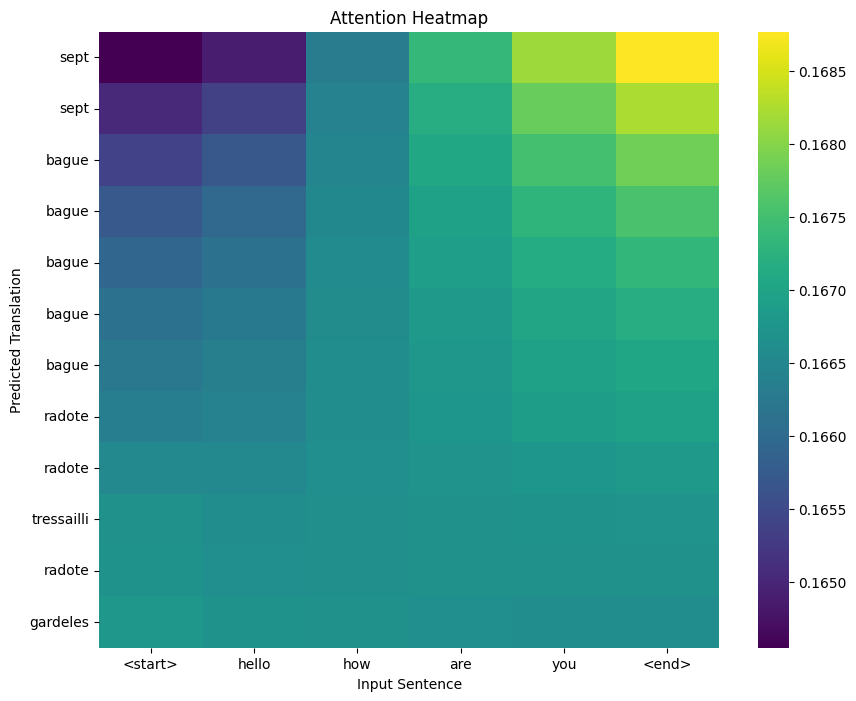

Input: hello
Predicted: sept sept bague bague bague bague bague radote radote tressailli radote gardeles


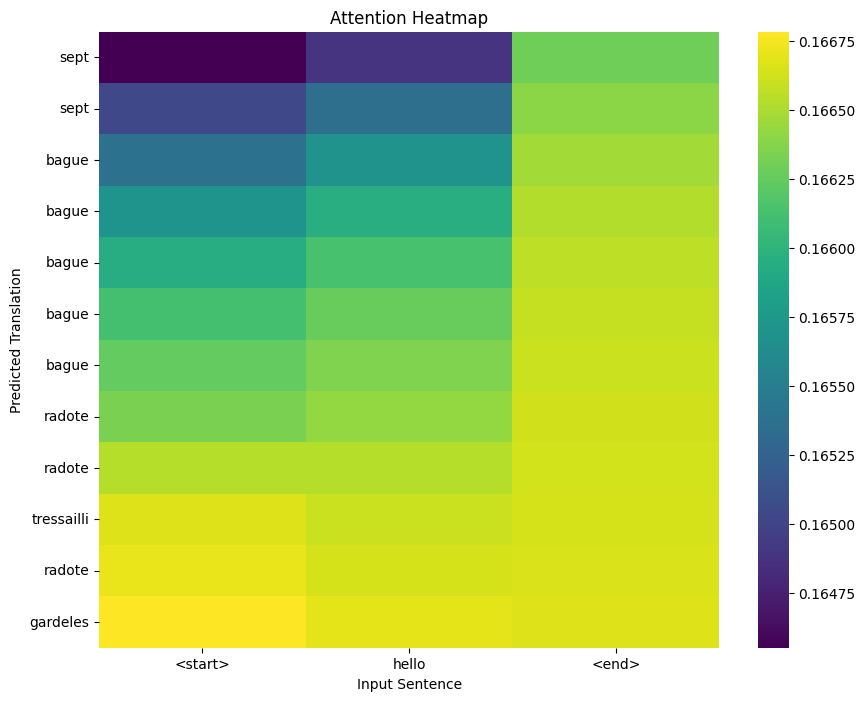

In [20]:
import seaborn as sns
# --- Test Translation and Visualization ---
english_input = "hello how are you"
french_output, attn_weights = translate_with_attention(english_input)

print("English:", english_input)
print("French:", french_output)

plot_attention(attn_weights, english_input, french_output)

# --- Additional Test ---
input_text = "hello"
output_text, attn = translate_with_attention(input_text)

print("Input:", input_text)
print("Predicted:", output_text)

plot_attention(attn, input_text, output_text)

TASK 7

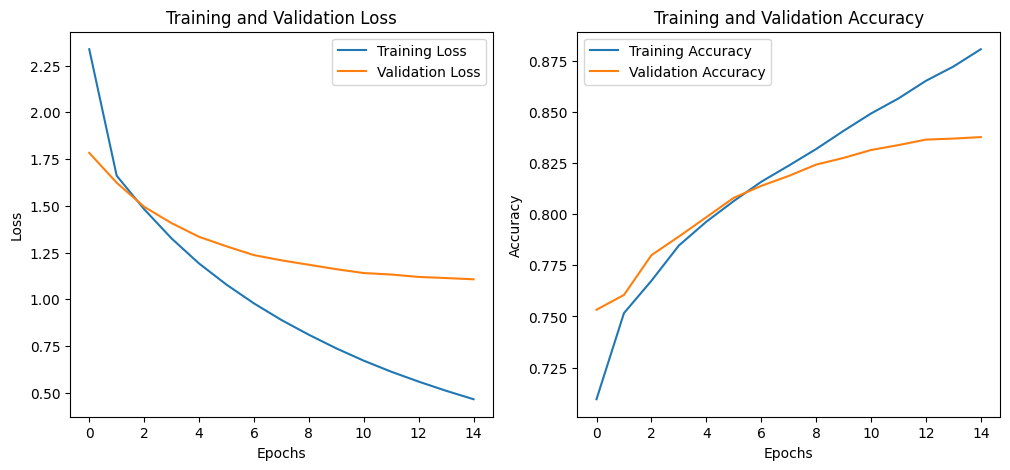

In [21]:
# Plotting Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()